# Image Generation for MNIST using VARIATIONAL AUTO ENCODER

### Autoencoders sequentially deconstruct input data into hidden representations and use those same representations to sequentially reconstruct outputs that resemble originals. A variational autoencoder (VAE) resembles a classical autoencoder and is a neural network consisting of an encoder, a decoder and a loss function. Our model is schotastic (randomly determined). 

### Importing all the necessary libraries

In [1]:
import matplotlib.pyplot as plt

In [2]:
 import numpy as np

In [3]:
from scipy.stats import norm

In [4]:
from keras.layers import Input, Dense, Lambda

Using TensorFlow backend.


In [5]:
from keras.models import Model
from keras import backend as K
from keras import objectives

In [6]:
from keras.datasets import mnist

### All necessary libraries have been imported

### Finding the hyperparameters and setting initial values for them.
### We initialize our encoder network. The job of the encoder is to map the input to its latent distribution parameters. We take the input data and send it through a dense fully-connected layer with our choice of non-linearity to squash dimensionality using the RELU function. 
### We convert input data into two parameters in a latent space. We pre-define the size of using dense fully connected layer z_mean and z_log_var

In [7]:
#hyperparameters
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 5
epsilon_std = 1.0

#encoder
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

print(z_mean)
print(z_log_var)

Tensor("dense_2/BiasAdd:0", shape=(100, 2), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(100, 2), dtype=float32)


### We are going to use z_mean and z_log_var to randomly sample new similar points from the latent normal distribution by defining a sampling function

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#latent hidden state
print(z)

Tensor("lambda_1/add:0", shape=(100, 2), dtype=float32)


### Once we have z, we can feed it to our decoder. The decoder would map the these latent space points back to the original input data. The decoder takes z as its input and outputs the parameters to the probability distribution of the data. We initialize the decoder with two fully connected layers and their own respective activation functions.

In [9]:
#decoder
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

print(x_decoded_mean)

Tensor("dense_5/Sigmoid:0", shape=(100, 784), dtype=float32)


### As the data is extracted from a small dimensionality to a larger one, some of it is lost in the reconstruction process. We need to minimize the loss function. The VAE has two loss terms. The first term measures the reconstruction loss. If the decoder output is bad at reconstructing the data well that would incur a large cost here. The next phase is the regularizer. Regularizing means keeping the representations of each digit as diverse as possible. We penalize bad behaviour and make sure similar representations are close together. The total loss function is sum of the reconstruction term and the KL divergence regularization term. We are using rmsprop which would be our optimizer for gradient descent. 

In [10]:
#loss
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

### Training the VAE on our dataset for a given number of epochs and batch size

In [11]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test),verbose=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 12s 207us/step - loss: 191.8889 - val_loss: 173.0947
Epoch 2/5
60000/60000 [==============================] - 10s 175us/step - loss: 170.9707 - val_loss: 168.7022
Epoch 3/5
60000/60000 [==============================] - 11s 178us/step - loss: 167.2853 - val_loss: 165.7519
Epoch 4/5
60000/60000 [==============================] - 11s 177us/step - loss: 164.9613 - val_loss: 164.1361
Epoch 5/5
60000/60000 [==============================] - 11s 177us/step - loss: 163.5268 - val_loss: 163.3053


### We are plotting the neighbourhood of the different classes on a 2D plane , each colored cluster represents a digit representation. Close clusters are digits that are structurally similar.

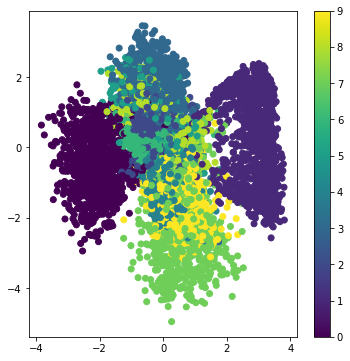

In [12]:
#plot latent/hidden space

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

### We can also generate digits by scanning the latent plane sampling latent points at regular intervals and generate corresponding digit for each of these points. 

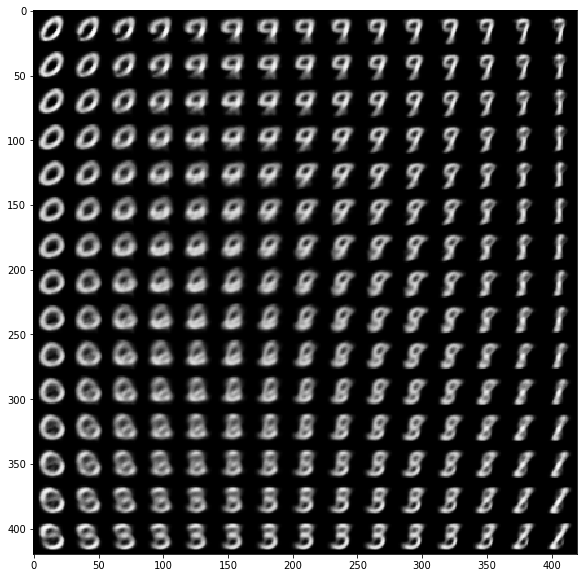

In [13]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### Variational auto-encoders allow us to generate data using unsupervised learning. They are a combination of back propagation and deep learning. We can back propagate through our network by performing a reparameterization step. Next steps will be to find better solution for image generation using GANs - a better and widely used method.